# Desafio DSA

## Janeiro 2019 - Diabetes

Jéssica Cabral

## Descrição do Problema

Nesta competição seu trabalho será criar um modelo de Machine Learning para prever a ocorrência de doenças.

<b>Métrica de Avaliação</b><br>
A métrica de avaliação para esta competição é a acurácia.

<b>Ferramenta</b><br>
Você pode usar a ferramenta com a qual se sentir mais confortável, mas recomendamos o uso de R, Python, Scala ou Java. Além do arquivo com as previsões, você deve submeter a solução completa que suporte as previsões. Isso pode ser feito enviando um kernel nesta competição.

<b>Formato do Envio da Solução</b><br>
Para cada paciente no conjunto de dados, o arquivo com a solução deve conter duas colunas: Id e classe com a previsão feita pelo modelo (0 - não possui a doença / 1 - possui a doença).

O arquivo deve conter um cabeçalho e ter o seguinte formato:
<br>Id,Classe
<br>1,1
<br>2,0
<br>3,0
<br>4,1
<br>etc.

# Imports

In [1]:
# Básico e essencial
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling

# ML
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import plot_importance

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('dataset_treino.csv')
test = pd.read_csv('dataset_teste.csv')

# Ignora a coluna id
train = train.drop('id', 1)
test = test.drop('id', 1)

print(train.shape)
print(test.shape)

(600, 9)
(168, 8)


In [3]:
train.describe()

,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade,classe
count,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000,600.000000
mean,3.820000,120.135000,68.681667,20.558333,79.528333,31.905333,0.481063,33.278333,0.346667
std,3.362009,32.658246,19.360226,16.004588,116.490583,8.009638,0.337284,11.822315,0.476306
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,0.000000,0.000000,27.075000,0.248000,24.000000,0.000000
50%,3.000000,116.000000,70.000000,23.000000,36.500000,32.000000,0.384000,29.000000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,122.750000,36.525000,0.647000,40.000000,1.000000
max,17.000000,198.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [4]:
test.describe()

,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,3.964286,124.148810,70.619048,20.827381,104.565476,32.304167,0.438583,33.125000
std,3.441370,30.106525,19.321673,15.577120,353.528165,7.433299,0.308102,11.565584
min,0.000000,56.000000,0.000000,0.000000,0.000000,0.000000,0.100000,21.000000
25%,1.000000,102.000000,62.000000,0.000000,0.000000,27.675000,0.222750,23.750000
50%,3.000000,120.000000,74.000000,23.000000,0.000000,32.400000,0.341500,28.000000
75%,6.000000,142.500000,80.500000,32.250000,136.250000,36.650000,0.588000,42.000000
max,13.000000,212.000000,114.000000,49.000000,4444.000000,57.300000,1.698000,70.000000


# Análise Exploratoria

In [5]:
pandas_profiling.ProfileReport(train)

Number of variables,9
Number of observations,600
Total Missing (%),0.0%
Total size in memory,42.3 KiB
Average record size in memory,72.1 B
Numeric,8
Categorical,0
Boolean,1
Date,0
Text (Unique),0
Rejected,0


Insulina, grossura da pele e num_gestacoes são as variaveis que mais apresentam números zerados dentro do dataset
Vamos precisar arrumar isso mais pra frente.

Outro ponto interessante é q somente BMI (e talve a glicose) possui uma distribuição normal, o restante das variaveis possuem uma positive skew

As classes estão desbalanceadas

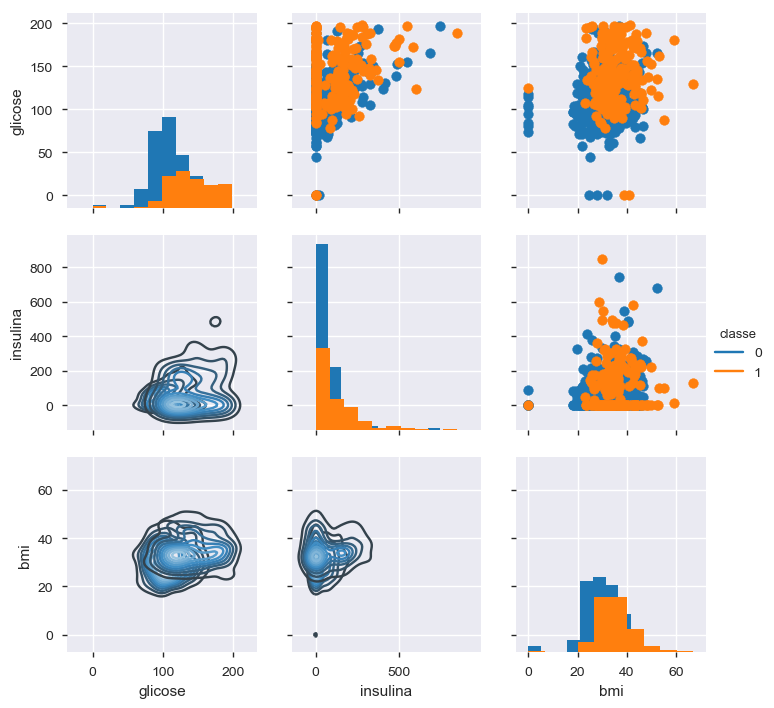

In [6]:
g = sns.PairGrid(train, vars=['glicose', 'insulina', 'bmi'], hue="classe", size=2.4)
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.add_legend()
plt.show()

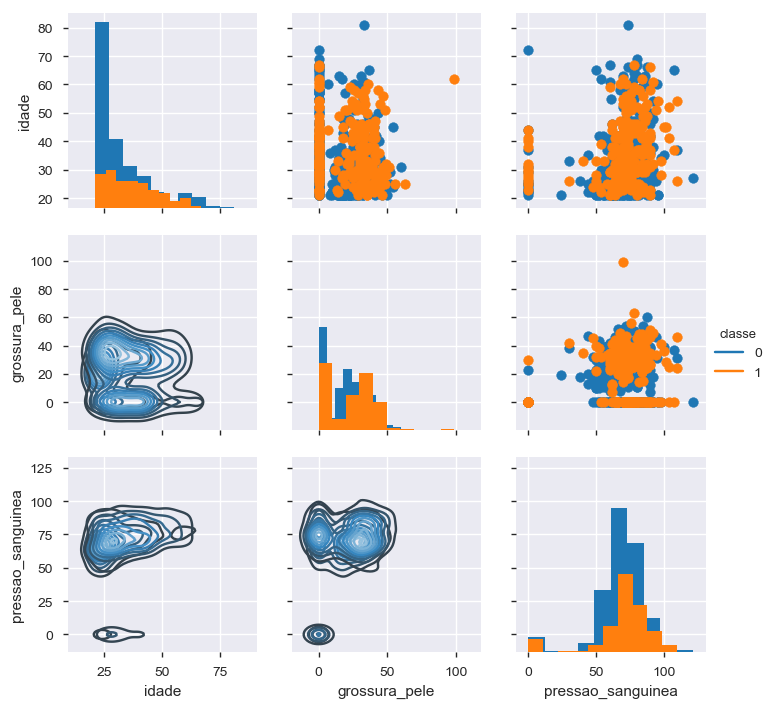

In [7]:
g = sns.PairGrid(train, vars=['idade', 'grossura_pele', 'pressao_sanguinea'], hue="classe", size=2.4)
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.add_legend()
plt.show()

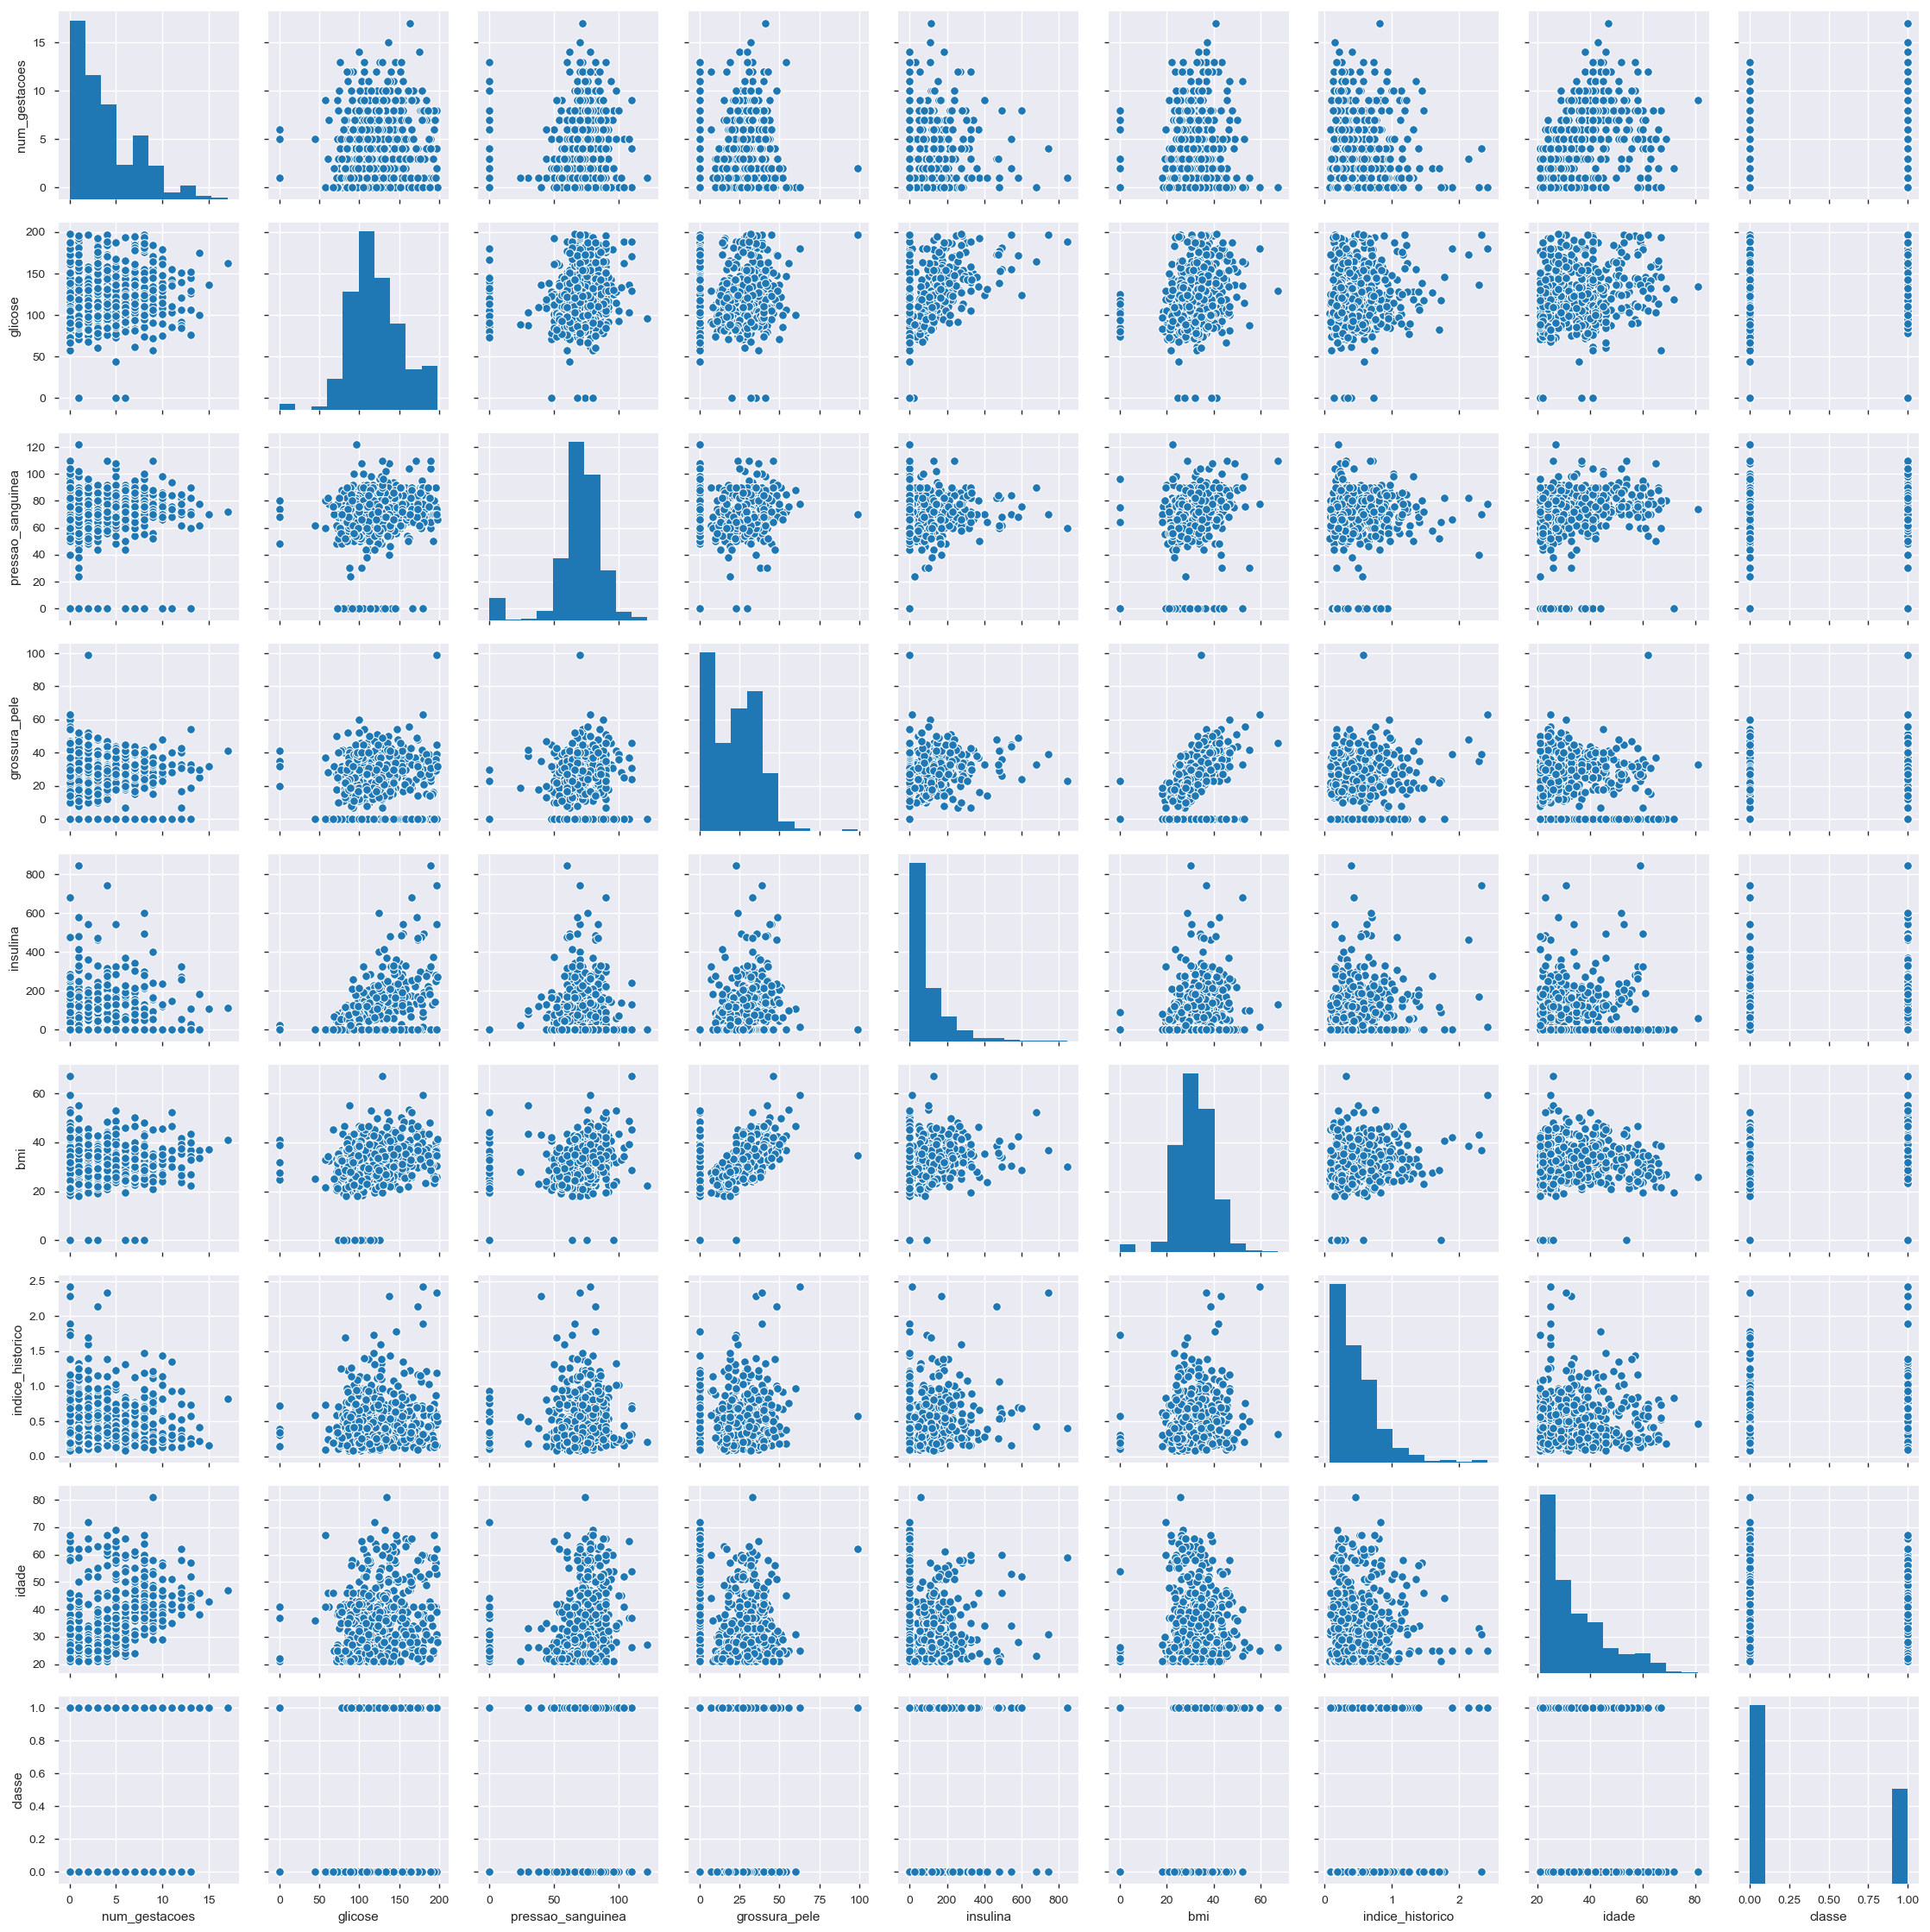

In [8]:
# Pairplot
sns.pairplot(train)

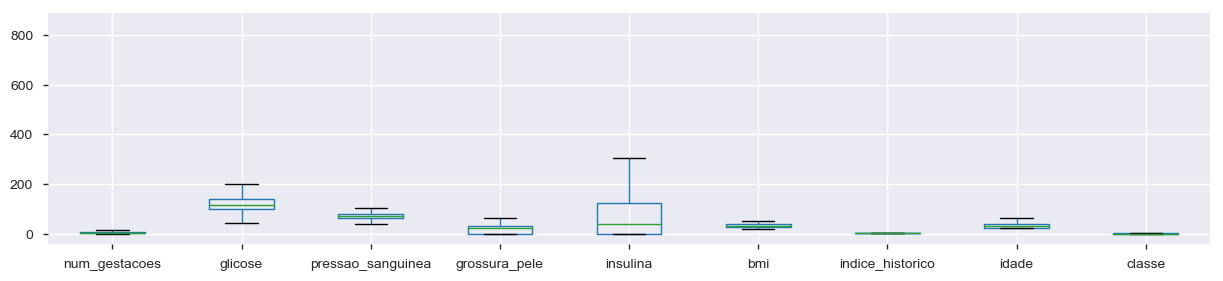

In [9]:
train.boxplot(figsize=(15,3));

Insulina e Grossura da pele parecem ter outilers. 

In [10]:
# Insulina

print('Valores mais altos')
print(train.insulina.sort_values(ascending=False)[:5])

print('\nValores mais Baixo')
print(train.insulina.sort_values(ascending=True)[:5])

print('\nDesvio padrão')
print(train.insulina.skew())


Valores mais altos
13     846
228    744
247    680
584    600
409    579
Name: insulina, dtype: int64

Valores mais Baixo
0      0
337    0
336    0
333    0
332    0
Name: insulina, dtype: int64

Desvio padrão
2.401175405415235


In [11]:
# Grossura da Pele

print('Valores mais altos')
print(train.grossura_pele.sort_values(ascending=False)[:5])

print('\nValores mais Baixo')
print(train.grossura_pele.sort_values(ascending=True)[:5])

print('\nDesvio padrão')
print(train.grossura_pele.skew())


Valores mais altos
579    99
445    63
57     60
120    56
86     54
Name: grossura_pele, dtype: int64

Valores mais Baixo
299    0
115    0
116    0
117    0
435    0
Name: grossura_pele, dtype: int64

Desvio padrão
0.16498533223258952


# Preprocessamento dos Dados

In [12]:
# copia do dataset train e test
train_mod = train.copy()
test_mod = test.copy()

In [13]:
# remove o Outlier da grossura da pele

max_grossura_pele = train_mod.grossura_pele.max()
print('valor maximo: {}'.format(max_grossura_pele))

train_mod = train_mod[train_mod.grossura_pele!=max_grossura_pele]

valor maximo: 99


In [14]:
# Subistitui os 0 das variaveis bmi, pressao_sanguinea, glicose, grossura_pele e insulina pela média

def replace_zero_train(df, field, target):
    mean_by_target = df.loc[df[field] != 0, [field, target]].groupby(target).mean()
    df.loc[(df[field] == 0)&(df[target] == 0), field] = mean_by_target.iloc[0][0]
    df.loc[(df[field] == 0)&(df[target] == 1), field] = mean_by_target.iloc[1][0]

def replace_zero_test(df, field, target):
    mean_by_target = df.loc[df[field] != 0, [field, target]].groupby(target).mean()
    df.loc[(df[field] == 0)&(df[target] == 0), field] = mean_by_target.iloc[0][0]

# cria coluna classe em teste para calculo na mediana por target
test_mod['classe'] = 0

for col in ['glicose', 'pressao_sanguinea', 'bmi', 'grossura_pele', 'insulina']:
    replace_zero_train(train_mod, col, 'classe')
    replace_zero_test(test_mod, col, 'classe') 

# remove coluna classe de test
test_mod = test_mod.drop('classe', 1)

In [15]:
# verifica se ainda tem algum valor zerado, excedo num_gestacoes e classe
print(train_mod.eq(0).any())
print()
print(test_mod.eq(0).any())

num_gestacoes         True
glicose              False
pressao_sanguinea    False
grossura_pele        False
insulina             False
bmi                  False
indice_historico     False
idade                False
classe                True
dtype: bool

num_gestacoes         True
glicose              False
pressao_sanguinea    False
grossura_pele        False
insulina             False
bmi                  False
indice_historico     False
idade                False
dtype: bool


# Modelagem Dos Dados

### Separa os dados Modificados

In [16]:
# Separa X e y
# com stratify
train_mod_raw , test_mod_raw = train_test_split(train_mod,test_size=0.3,random_state=100,stratify=train_mod.classe) 


Xm_train = train_mod_raw[train_mod_raw.columns[:8]]
Xm_test = test_mod_raw[test_mod_raw.columns[:8]]
ym_train = train_mod_raw['classe']
ym_test = test_mod_raw['classe']

(Xm_train.shape, ym_train.shape, Xm_test.shape, ym_test.shape)

((419, 8), (419,), (180, 8), (180,))

### Aplica Smote

Relembrando:

Xm_train/ym_train/Xm_test/ym_test = Somente dados modificados (train_mod)

Xs_train/ys_train/Xs_test/ys_test = Dados com SMOTE

# Modelo

In [17]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

## v1 - Sem rebalanceamento

In [18]:
# Criando o modelo v1
xgb_model = XGBClassifier(random_state=8)
xgb_model.fit(Xm_train, ym_train)

print(xgb_model)

# Evaluation

# Predição nos dados de treino
y_xgb_pred_train = xgb_model.predict(Xm_train)
print('XGboost Train Report %r' % (classification_report(ym_train, y_xgb_pred_train)))
print("\n Accuracy for XGBoost Train: %.2f%%" % (accuracy_score(ym_train, y_xgb_pred_train) * 100))

# Predição nos dados de teste
y_xgb_pred = xgb_model.predict(Xm_test)
print('XGboost Test Report %r' % (classification_report(ym_test, y_xgb_pred)))
print("\n Accuracy for XGBoost Test: %.2f%%" % (accuracy_score(ym_test, y_xgb_pred) * 100))

matrix = cross_val_predict(xgb_model, Xm_train, ym_train, cv=10)
pd.DataFrame(confusion_matrix(ym_train, matrix), columns=['True', 'False'], index=['True', 'False'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=8,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
XGboost Train Report '              precision    recall  f1-score   support\n\n           0       0.97      0.99      0.98       274\n           1       0.99      0.95      0.97       145\n\n   micro avg       0.98      0.98      0.98       419\n   macro avg       0.98      0.97      0.98       419\nweighted avg       0.98      0.98      0.98       419\n'

 Accuracy for XGBoost Train: 97.85%
XGboost Test Report '              precision    recall  f1-score   support\n\n           0       0.91      0.92      0.91       118\n           1       0.84      0.82      0.83        62\n\n   micro avg       0.88    

,True,False
True,249,25
False,33,112


## v2 - Com rebalanceamento

## Grid Search no modelo v1

In [19]:
# Parameter grid para o XGBoostClassifier
param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5],
        'learning_rate': [0.01, 0.02, 0.1, 0.15, 0.2],
        'n_estimators': range(10,400, 100)
    }

# Modelo identico ao da v1
xgb_v2 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=8,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

random_search = RandomizedSearchCV(xgb_v2, param_distributions=param_grid, n_iter=param_comb, scoring='accuracy', 
                                   cv=skf.split(Xm_train,ym_train), verbose=3, random_state=1001)

random_search.fit(Xm_train, ym_train)

print('\n All results:')
print(random_search.cv_results_)

print('\n Best estimator:')
print(random_search.best_estimator_)

print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)

print('\n Best hyperparameters:')
print(random_search.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] subsample=0.8, n_estimators=10, min_child_weight=1, max_depth=3, learning_rate=0.01, gamma=2, colsample_bytree=1.0 
[CV]  subsample=0.8, n_estimators=10, min_child_weight=1, max_depth=3, learning_rate=0.01, gamma=2, colsample_bytree=1.0, score=0.8226950354609929, total=   0.0s
[CV] subsample=0.8, n_estimators=10, min_child_weight=1, max_depth=3, learning_rate=0.01, gamma=2, colsample_bytree=1.0 
[CV]  subsample=0.8, n_estimators=10, min_child_weight=1, max_depth=3, learning_rate=0.01, gamma=2, colsample_bytree=1.0, score=0.8345323741007195, total=   0.0s
[CV] subsample=0.8, n_estimators=10, min_child_weight=1, max_depth=3, learning_rate=0.01, gamma=2, colsample_bytree=1.0 
[CV]  subsample=0.8, n_estimators=10, min_child_weight=1, max_depth=3, learning_rate=0.01, gamma=2, colsample_bytree=1.0, score=0.8705035971223022, total=   0.0s
[CV] subsample=0.8, n_estimators=10, min_child_weight=1, max_depth=4, learning_rate=0.1, ga

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s


[CV] subsample=0.8, n_estimators=310, min_child_weight=10, max_depth=4, learning_rate=0.1, gamma=0.5, colsample_bytree=0.6 
[CV]  subsample=0.8, n_estimators=310, min_child_weight=10, max_depth=4, learning_rate=0.1, gamma=0.5, colsample_bytree=0.6, score=0.8129496402877698, total=   0.0s
[CV] subsample=0.8, n_estimators=310, min_child_weight=10, max_depth=4, learning_rate=0.1, gamma=0.5, colsample_bytree=0.6 
[CV]  subsample=0.8, n_estimators=310, min_child_weight=10, max_depth=4, learning_rate=0.1, gamma=0.5, colsample_bytree=0.6, score=0.8848920863309353, total=   0.0s
[CV] subsample=1.0, n_estimators=10, min_child_weight=10, max_depth=3, learning_rate=0.02, gamma=5, colsample_bytree=1.0 
[CV]  subsample=1.0, n_estimators=10, min_child_weight=10, max_depth=3, learning_rate=0.02, gamma=5, colsample_bytree=1.0, score=0.8439716312056738, total=   0.0s
[CV] subsample=1.0, n_estimators=10, min_child_weight=10, max_depth=3, learning_rate=0.02, gamma=5, colsample_bytree=1.0 
[CV]  subsample

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.2s finished


## v3 - Sem rebalanceamento e best hyperparameters do GridSearch

In [20]:
# Criando o modelo v3
xgb_v3 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=110,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=8,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)
xgb_v3.fit(Xm_train, ym_train)

print(xgb_v3)

# Evaluation

# Predição nos dados de treino
y_xgb3_pred_train = xgb_v3.predict(Xm_train)
print('XGboost Train Report %r' % (classification_report(ym_train, y_xgb3_pred_train)))
print("\n Accuracy for XGBoost Train: %.2f%%" % (accuracy_score(ym_train, y_xgb3_pred_train) * 100))

# Predição nos dados de teste
y_xgb3_pred = xgb_v3.predict(Xm_test)
print('XGboost Test Report %r' % (classification_report(ym_test, y_xgb3_pred)))
print("\n Accuracy for XGBoost Test: %.2f%%" % (accuracy_score(ym_test, y_xgb3_pred) * 100))

matrix = cross_val_predict(xgb_v3, Xm_train, ym_train, cv=10)
pd.DataFrame(confusion_matrix(ym_train, matrix), columns=['True', 'False'], index=['True', 'False'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=110,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=8,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)
XGboost Train Report '              precision    recall  f1-score   support\n\n           0       0.91      0.96      0.94       274\n           1       0.92      0.83      0.87       145\n\n   micro avg       0.91      0.91      0.91       419\n   macro avg       0.91      0.89      0.90       419\nweighted avg       0.91      0.91      0.91       419\n'

 Accuracy for XGBoost Train: 91.41%
XGboost Test Report '              precision    recall  f1-score   support\n\n           0       0.93      0.93      0.93       118\n           1       0.87      0.87      0.87        62\n\n   micro avg       0.91

,True,False
True,252,22
False,30,115


Acuracia do modelo em teste ficou em 91.11%

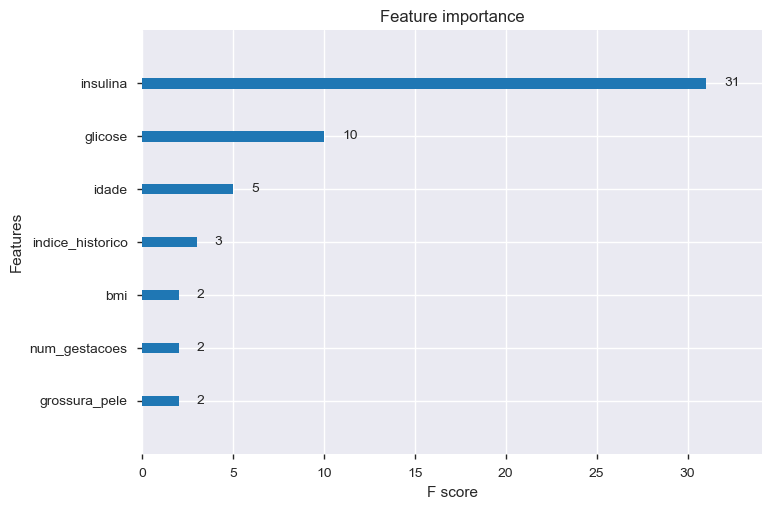

In [21]:
# plot feature importance

plot_importance(xgb_v3)
plt.show()

## Usando Apenas as Features Mais Importantes

In [22]:
train2=train_mod[['insulina','glicose','idade','indice_historico','bmi', 'classe']]

print(train2.shape)

# if = importante features
train2_if, test2_if = train_test_split(train2,test_size=0.30,random_state=100,stratify=train2.classe)

Xif_train = train2_if[train2_if.columns[:5]]
Xif_test = test2_if[test2_if.columns[:5]]
yif_train = train2_if['classe']
yif_test = test2_if['classe']

(Xif_train.shape, yif_train.shape, Xif_test.shape, yif_test.shape)

(599, 6)


((419, 5), (419,), (180, 5), (180,))

In [23]:
# Criando o modelo v4
xgb_v4 = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=110,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=8,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)
xgb_v4.fit(Xif_train, yif_train)

print(xgb_v4)

# Evaluation

# Predição nos dados de treino
y_xgb4_pred_train = xgb_v4.predict(Xif_train)
print('XGboost Train Report %r' % (classification_report(yif_train, y_xgb4_pred_train)))
print("\n Accuracy for XGBoost Train: %.2f%%" % (accuracy_score(yif_train, y_xgb4_pred_train) * 100))

# Predição nos dados de teste
y_xgb4_pred = xgb_v4.predict(Xif_test)
print('XGboost Test Report %r' % (classification_report(yif_test, y_xgb4_pred)))
print("\n Accuracy for XGBoost Test: %.2f%%" % (accuracy_score(yif_test, y_xgb4_pred) * 100))

matrix = cross_val_predict(xgb_v4, Xif_train, yif_train, cv=10)
pd.DataFrame(confusion_matrix(yif_train, matrix), columns=['True', 'False'], index=['True', 'False'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=5, learning_rate=0.2, max_delta_step=0,
       max_depth=3, min_child_weight=5, missing=None, n_estimators=110,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=8,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1.0)
XGboost Train Report '              precision    recall  f1-score   support\n\n           0       0.91      0.94      0.92       274\n           1       0.88      0.83      0.85       145\n\n   micro avg       0.90      0.90      0.90       419\n   macro avg       0.89      0.88      0.89       419\nweighted avg       0.90      0.90      0.90       419\n'

 Accuracy for XGBoost Train: 89.98%
XGboost Test Report '              precision    recall  f1-score   support\n\n           0       0.93      0.92      0.93       118\n           1       0.86      0.87      0.86        62\n\n   micro avg       0.91

,True,False
True,252,22
False,30,115


Mesmo testando todas as variações do feature importante nenhuma deu um resultado melhor do que nosso modelo xgb_v3

# Aplicando no dataset de teste

In [24]:
# relembrando o estado do nosso dataset de teste ja modificado
# foi aplicado anteriormente: média por targer nas variaveis 0
test_mod.head()

,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade
0,1,108.0,88.000000,19.000000,211.650602,27.1,0.400,24
1,6,96.0,73.689441,29.403361,211.650602,23.7,0.190,28
2,1,124.0,74.000000,36.000000,211.650602,27.8,0.100,30
3,7,150.0,78.000000,29.000000,126.000000,35.2,0.692,54
4,4,183.0,73.689441,29.403361,211.650602,28.4,0.212,36


In [25]:
test_mod.describe()

,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,3.964286,124.148810,73.689441,29.403361,211.650602,32.693373,0.438583,33.125000
std,3.441370,30.106525,12.457947,7.934854,337.220560,6.527300,0.308102,11.565584
min,0.000000,56.000000,44.000000,10.000000,15.000000,19.500000,0.100000,21.000000
25%,1.000000,102.000000,64.000000,25.750000,143.000000,27.950000,0.222750,23.750000
50%,3.000000,120.000000,74.000000,29.403361,211.650602,32.500000,0.341500,28.000000
75%,6.000000,142.500000,80.500000,32.250000,211.650602,36.650000,0.588000,42.000000
max,13.000000,212.000000,114.000000,49.000000,4444.000000,57.300000,1.698000,70.000000


In [26]:
# checando o dataset
pandas_profiling.ProfileReport(test_mod)

Number of variables,8
Number of observations,168
Total Missing (%),0.0%
Total size in memory,10.6 KiB
Average record size in memory,64.5 B
Numeric,8
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


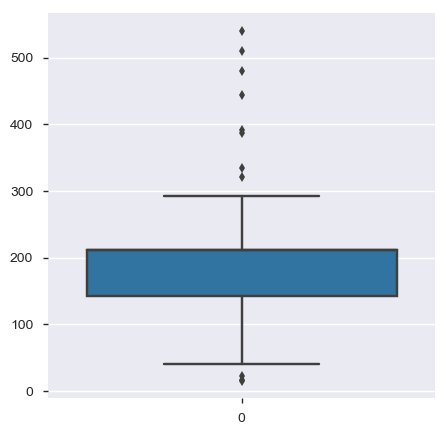

In [33]:
plt.figure(figsize=(5,5))
sns.boxplot(data=test_mod.insulina);

In [28]:
test_mod.sort_values(by='insulina', ascending=False)['insulina'][:10]

45     4444.0
55      540.0
153     510.0
95      480.0
115     392.0
110     387.0
107     335.0
12      321.0
6       293.0
113     291.0
Name: insulina, dtype: float64

Insulina possui um outlier no valor de 4444, que provavelmente era 444

Vamos aceitar que 444 era o valor correto e corrigir

In [29]:
print('Registro com valor anomalo: {}'.format(test_mod[test_mod.insulina == 4444]['insulina']))

test_mod.insulina.replace(4444, 444, inplace = True)

print()
print('Registro com valor anomalo: {}'.format(test_mod[test_mod.insulina == 4444]['insulina']))

test_mod.sort_values(by='insulina', ascending=False)['insulina'][:10]

Registro com valor anomalo: 45    4444.0
Name: insulina, dtype: float64

Registro com valor anomalo: Series([], Name: insulina, dtype: float64)


55     540.0
153    510.0
95     480.0
45     444.0
115    392.0
110    387.0
107    335.0
12     321.0
6      293.0
113    291.0
Name: insulina, dtype: float64

In [30]:
test_mod.describe()

,num_gestacoes,glicose,pressao_sanguinea,grossura_pele,insulina,bmi,indice_historico,idade
count,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000,168.000000
mean,3.964286,124.148810,73.689441,29.403361,187.841079,32.693373,0.438583,33.125000
std,3.441370,30.106525,12.457947,7.934854,78.794191,6.527300,0.308102,11.565584
min,0.000000,56.000000,44.000000,10.000000,15.000000,19.500000,0.100000,21.000000
25%,1.000000,102.000000,64.000000,25.750000,143.000000,27.950000,0.222750,23.750000
50%,3.000000,120.000000,74.000000,29.403361,211.650602,32.500000,0.341500,28.000000
75%,6.000000,142.500000,80.500000,32.250000,211.650602,36.650000,0.588000,42.000000
max,13.000000,212.000000,114.000000,49.000000,540.000000,57.300000,1.698000,70.000000


In [31]:
# Predicao
ynew = xgb_v3.predict(test_mod)

print("Classe '0': {}".format(sum(ynew==0)))
print("Classe '1': {}".format(sum(ynew==1)))

Classe '0': 109
Classe '1': 59


In [32]:
# Generate the submission file

predictions = pd.DataFrame(test_mod.index, columns=['id'])

predictions['classe'] = ynew#.astype(int)

predictions.to_csv("submission_final_jessica.csv", index=False)